<a href="https://colab.research.google.com/github/imranmurtaza110/RL_Lunar_lander/blob/main/lunar_lander_updated_hyperparameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gymnasium
!pip install swig
!apt-get install -y python-box2d
!pip install gymnasium[box2d]
!pip install pyvirtualdisplay
!apt-get update
!apt-get install -y xvfb
!apt-get update
!apt-get install -y xvfb python-opengl ffmpeg swig

In [2]:
from pyvirtualdisplay import Display
from IPython.display import display as ipy_display, HTML
from base64 import b64encode
display = Display(visible=0, size=(1400, 900))
display.start()

from gymnasium.wrappers import RecordVideo

In [3]:
import gymnasium as gym

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

# Deep learning model with fully connected layers
class DeepQLearning(nn.Module):
  def __init__(self, fc_1, fc_2, fc_3):
      super().__init__()
      self.model = nn.Sequential(
            nn.Linear(8, fc_1),
            nn.ReLU(),
            nn.Linear(fc_1, fc_2),
            nn.ReLU(),
            nn.Linear(fc_2, fc_3),
            nn.ReLU(),
            nn.Linear(fc_3, 4)
        )

  def forward(self, x):
    return self.model(x)

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
# Loss Function class with adam optimizer
class LossFunction:
  def __init__(self, model, lr):
        self.model = model
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

  def step(self, loss):
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()


In [36]:
import numpy as np
import random
from collections import deque
from math import sqrt, log

"""
  Epsilon-greedy strategy is used for action selection in Agent class.
  Manages an experience replay buffer and a neural network model for decision-making.
  Epsilon, representing the exploration rate, decays over time but is bounded by a minimum threshold.
  Employs the Bellman equation for updating the model based on stored experiences.
"""
class Agent:
  def __init__(self, action_space, observation_space, epsilon, min_epsilon, epsilon_decay, lr, model):
    self.action_space = action_space
    self.observation_space = observation_space
    self.epsilon = epsilon
    self.epsilon_decay = epsilon_decay
    self.experience_buffer = deque(maxlen=5000000)
    self.model = model
    self.min_epsilon = min_epsilon
    self.optimizer = LossFunction(self.model, lr=lr)


  def update_epsilon(self):
        if self.epsilon not in [0.01]:
          if self.epsilon > self.min_epsilon:
            self.epsilon -= self.epsilon_decay
          elif self.epsilon < 0:
            self.epsilon = self.min_epsilon
        return self.epsilon

  def select_action(self, state):
    if np.random.random() < self.epsilon:
        return np.random.randint(self.action_space)
    else:
        if not state[1]:
          state_tensor = torch.FloatTensor(state[0][0:8]).unsqueeze(0)
        else:
          state_tensor = torch.FloatTensor(state).unsqueeze(0)

        act_values = self.model(state_tensor)
        return torch.argmax(act_values).item()


  def experience_replay_buffer(self, state, action, reward, next_state, done):
      self.experience_buffer.append((state, action, reward, next_state, done))


  def play(self, batch_size, gamma):
        if len(self.experience_buffer) < batch_size:
            return

        batch = random.sample(self.experience_buffer, batch_size)

        states = []
        actions = []
        rewards = []
        next_states = []
        is_done = []

        for experience in batch:
            state, action, reward, next_state, done = experience
            states.append(experience[0])
            actions.append(experience[1])
            rewards.append(experience[2])
            next_states.append(experience[3])
            is_done.append(experience[4])

        states_flat = []
        for entry in states:
            if isinstance(entry, tuple) and len(entry) == 2:
                states_flat.append(entry[0])
            else:
                states_flat.append(entry)

        states_tensor = torch.tensor(states_flat, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        is_done = torch.tensor(is_done, dtype=torch.float32)

        q_values = self.model(states_tensor)
        next_q_values = self.model(next_states)

        target_q_values = self.calculate_q_values(rewards, gamma, next_q_values, is_done)

        loss = nn.MSELoss()(q_values[range(batch_size), actions], target_q_values)

        self.optimizer.step(loss)

  # bellman equation
  def calculate_q_values(self, rewards, gamma, next_q_values, is_done):
    target_q_values = []
    for i in range(len(rewards)):
        if is_done[i] == 0:
            target_q = rewards[i]
        else:
            target_q = rewards[i] + gamma * torch.max(next_q_values[i]) * (1 - is_done[i])

        target_q_values.append(target_q)
    target_q_values = torch.tensor(target_q_values)
    return target_q_values

In [60]:
import matplotlib.pyplot as plt

# Different graphs are used for data visualization

def plot_steps_per_episode(episodes, steps_per_episode):
  x_axis = episodes
  y_axis = steps_per_episode
  plt.plot(x_axis, y_axis)
  plt.xlabel('Episodes')
  plt.ylabel('Steps')
  plt.title('Steps / Episodes')
  plt.show()

def plot_rewards_per_episode(episodes, rewards):
  x_axis = episodes
  y_axis = rewards

  plt.plot(x_axis, y_axis)
  plt.xlabel('Episode')
  plt.ylabel('Reward')
  plt.title('Reward / Episode')
  plt.show()


def plot_cumulative_rewards(episodes, episode_rewards):
    avg_rewards = [sum(episode_rewards[:i+1]) / len(episode_rewards[:i+1]) for i in range(len(episode_rewards))]
    plt.plot(episodes, avg_rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Commulative Reward')
    plt.title('Commulative Reward / Episodes')
    plt.show()


def plot_average_reward_per_hundred_episodes(episodes, episode_rewards):
    num_chunks = len(episode_rewards) // 100

    average_rewards = []
    episode_indices = []

    for i in range(num_chunks):
        start_index = i * 100
        end_index = start_index + 100
        chunk = episode_rewards[start_index:end_index]
        average_reward = sum(chunk) / 100

        average_rewards.append(average_reward)
        episode_indices.append(episodes[end_index - 1])

    plt.plot(episode_indices, average_rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward')
    plt.title('Average Reward Per 100 Episodes')
    plt.show()

In [81]:
# Create the environment
import time


def testbed(epi, steps_taken, epsilon, min_epsilon, epsilon_decay, lr, fc_1, fc_2, fc_3, batch_size, gamma):

  env = gym.make(
      "LunarLander-v2",
      render_mode="rgb_array",

  )

  # Fixing seeds
  gym.envs.register(
      id='LunarLander-seed-v2',
      entry_point='gym.envs.box2d:LunarLander',
      kwargs={'seed': 72}  # Pass the seed as a keyword argument
  )

  video_folder = "/content/videos"

  folder = video_folder + f"/episode_{2}"
  # # wrap the env in the record video
  env = gym.wrappers.RecordVideo(
      env,
      "folder",  # Replace with your desired folder path
      name_prefix="video-",
      episode_trigger=lambda x: x % 50 == 0
  )

  observation_shape = env.observation_space.shape

  num_actions = env.action_space.n
  model = DeepQLearning(fc_1, fc_2, fc_3)

  # Initialize the agent
  agent = Agent(num_actions, observation_shape, epsilon, min_epsilon, epsilon_decay, lr, model)

  # Main loop
  episodes = []
  steps_per_episode = []
  episode_rewards = []
  time_limit_seconds = 30
  # env reset for a fresh start
  observation, info = env.reset()
  env.start_video_recorder()
  observation = env.reset()

  for i in range(epi):

    state = env.reset()

    total_reward = 0
    start_time = time.time()
    for j in range(steps_taken):  # Maximum episode length
        action = agent.select_action(state)
        next_state, reward, done, _, _ = env.step(action)
        agent.experience_replay_buffer(state, action, reward, next_state, done)
        state = next_state
        agent.play(batch_size=batch_size, gamma=gamma)
        total_reward += reward

        elapsed_time = time.time() - start_time

        if done or elapsed_time >= time_limit_seconds or j == (steps_taken-1):
            done = True
            episodes.append(i+1)
            steps_per_episode.append(j)
            episode_rewards.append(total_reward)
            print('total episodes: ' + str(i))
            print('total time: ' + str(elapsed_time))
            print('total steps to complete the episode: ' + str(j))
            print('reward for current state: ' + str(reward))
            print('reward for this episode: ' + str(total_reward))
            print('\n')
            break




    #  printing graph after every 100 iterations to visualize it
    if (i+1) % 100 == 0:
      plot_steps_per_episode(episodes, steps_per_episode)
      plot_rewards_per_episode(episodes, episode_rewards)
      plot_cumulative_rewards(episodes, episode_rewards)
      plot_average_reward_per_hundred_episodes(episodes, episode_rewards)

    env.render()
    epsilon_value = agent.update_epsilon()
    env.close_video_recorder()
    env.close()

  return episodes, steps_per_episode, episode_rewards,




Moviepy - Building video /content/folder/video--episode-0.mp4.
Moviepy - Writing video /content/folder/video--episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-0.mp4


Moviepy - Building video /content/folder/video--episode-0.mp4.
Moviepy - Writing video /content/folder/video--episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-0.mp4
total episodes: 0
total time: 1.1060867309570312
total steps to complete the episode: 56
reward for current state: -100
reward for this episode: -179.54122803753071


total episodes: 1
total time: 1.385699987411499
total steps to complete the episode: 120
reward for current state: -100
reward for this episode: -226.01596279852117


total episodes: 2
total time: 0.5194230079650879
total steps to complete the episode: 101
reward for current state: -100
reward for this episode: -400.5304958365351


total episodes: 3
total time: 1.5846672058105469
total steps to complete the episode: 220
reward for current state: -100
reward for this episode: -115.17203020658175


total episodes: 4
total time: 0.6642246246337891
total steps to complete the episode: 144
reward for current state: -100
reward for this episode: -197.80726876823093


total episodes: 5
total time: 0.5614287853240967
total steps to complete the episode: 1

Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-50.mp4


Moviepy - Building video /content/folder/video--episode-50.mp4.
Moviepy - Writing video /content/folder/video--episode-50.mp4



Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-50.mp4
total episodes: 50
total time: 2.228761672973633
total steps to complete the episode: 156
reward for current state: -100
reward for this episode: -30.617626428242943


total episodes: 51
total time: 1.38621187210083
total steps to complete the episode: 264
reward for current state: -100
reward for this episode: -273.0965854045519


total episodes: 52
total time: 1.531367540359497
total steps to complete the episode: 213
reward for current state: -100
reward for this episode: -219.29612539509995


total episodes: 53
total time: 1.8132870197296143
total steps to complete the episode: 279
reward for current state: -100
reward for this episode: -66.15663341976848


total episodes: 54
total time: 0.7859454154968262
total steps to complete the episode: 155
reward for current state: -100
reward for this episode: -63.934080997435274


total episodes: 55
total time: 1.2777760028839111
total steps to complete the episod

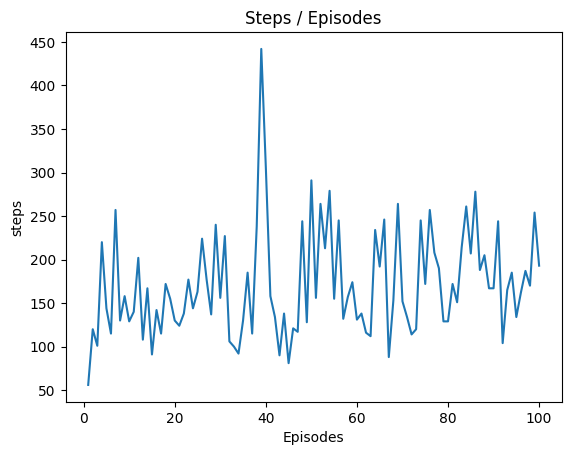

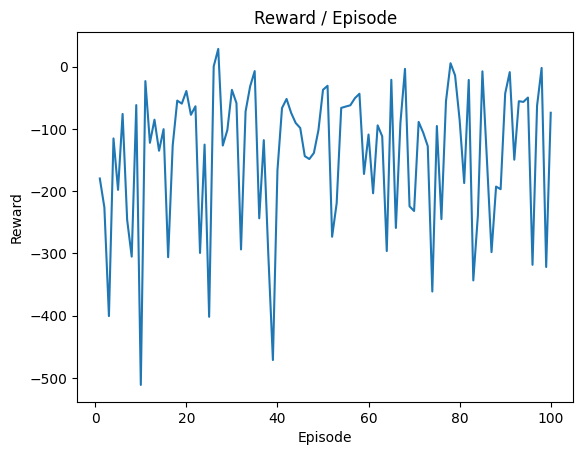

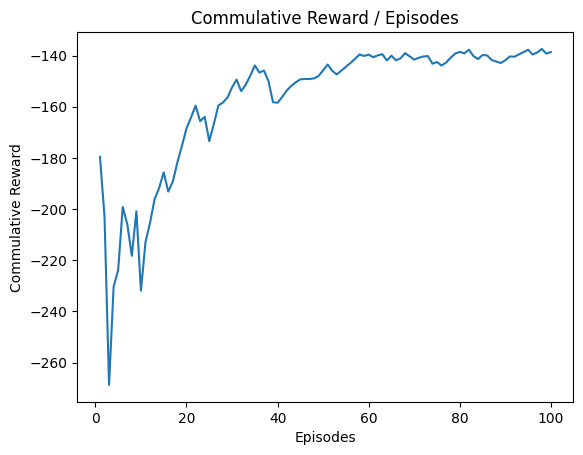

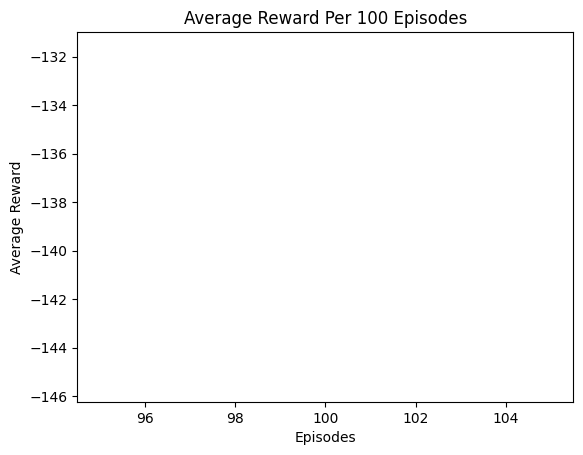

Moviepy - Building video /content/folder/video--episode-100.mp4.
Moviepy - Writing video /content/folder/video--episode-100.mp4



Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-100.mp4


Moviepy - Building video /content/folder/video--episode-100.mp4.
Moviepy - Writing video /content/folder/video--episode-100.mp4



Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-100.mp4
total episodes: 100
total time: 1.6917762756347656
total steps to complete the episode: 91
reward for current state: -100
reward for this episode: -105.90231349293718


total episodes: 101
total time: 2.2582578659057617
total steps to complete the episode: 302
reward for current state: -100
reward for this episode: -119.06932745620037


total episodes: 102
total time: 1.5243489742279053
total steps to complete the episode: 282
reward for current state: -100
reward for this episode: -104.77886355899142


total episodes: 103
total time: 1.0131266117095947
total steps to complete the episode: 190
reward for current state: -100
reward for this episode: -185.37640180352707


total episodes: 104
total time: 1.3858270645141602
total steps to complete the episode: 276
reward for current state: -100
reward for this episode: -236.52746743066996


total episodes: 105
total time: 1.7231693267822266
total steps to complet

Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-150.mp4


Moviepy - Building video /content/folder/video--episode-150.mp4.
Moviepy - Writing video /content/folder/video--episode-150.mp4



Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-150.mp4
total episodes: 150
total time: 5.917712450027466
total steps to complete the episode: 333
reward for current state: -100
reward for this episode: -110.86067389559354


total episodes: 151
total time: 1.1513068675994873
total steps to complete the episode: 154
reward for current state: -100
reward for this episode: -249.00023201433197


total episodes: 152
total time: 1.609889030456543
total steps to complete the episode: 288
reward for current state: -100
reward for this episode: -267.92625026750426


total episodes: 153
total time: 0.9720804691314697
total steps to complete the episode: 190
reward for current state: -100
reward for this episode: -159.83090737030062


total episodes: 154
total time: 0.8955280780792236
total steps to complete the episode: 174
reward for current state: -100
reward for this episode: -165.92984011787837


total episodes: 155
total time: 1.3766417503356934
total steps to complete

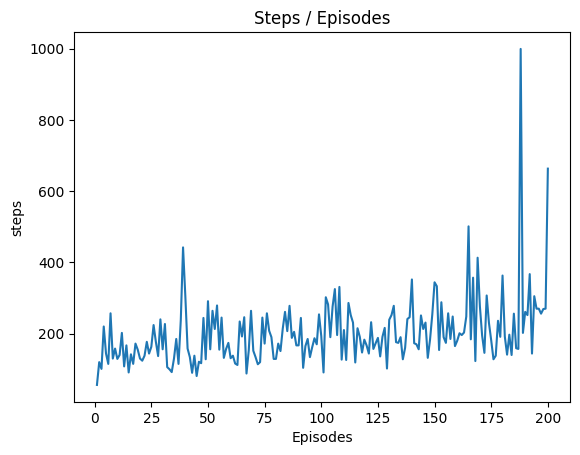

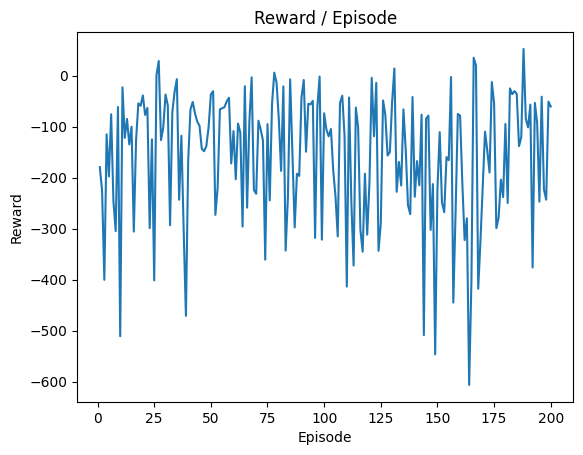

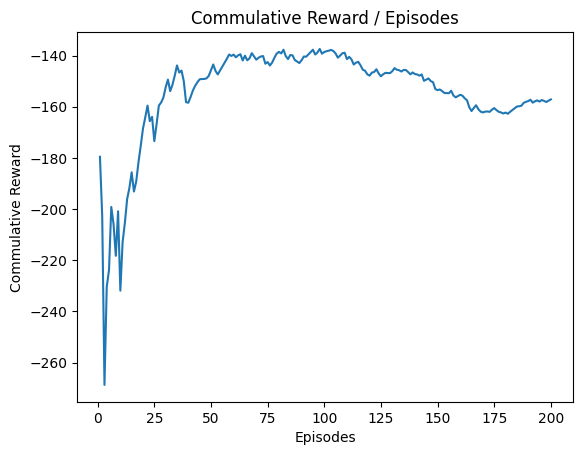

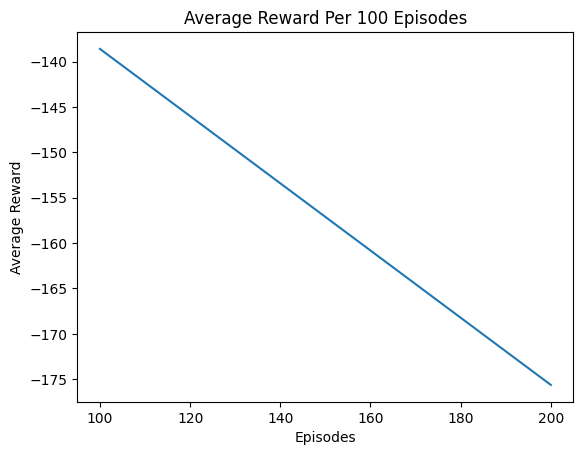

Moviepy - Building video /content/folder/video--episode-200.mp4.
Moviepy - Writing video /content/folder/video--episode-200.mp4



Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-200.mp4


Moviepy - Building video /content/folder/video--episode-200.mp4.
Moviepy - Writing video /content/folder/video--episode-200.mp4



Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-200.mp4
total episodes: 200
total time: 2.662606954574585
total steps to complete the episode: 144
reward for current state: -100
reward for this episode: -1.0267135033233785


total episodes: 201
total time: 2.3557558059692383
total steps to complete the episode: 351
reward for current state: -100
reward for this episode: -66.87412438467294


total episodes: 202
total time: 1.8512797355651855
total steps to complete the episode: 333
reward for current state: -100
reward for this episode: -17.100936224392314


total episodes: 203
total time: 1.7235164642333984
total steps to complete the episode: 317
reward for current state: -100
reward for this episode: -252.6055631467721


total episodes: 204
total time: 1.2665214538574219
total steps to complete the episode: 249
reward for current state: -100
reward for this episode: -54.21666549590862


total episodes: 205
total time: 1.0539145469665527
total steps to complete t

Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-250.mp4


Moviepy - Building video /content/folder/video--episode-250.mp4.
Moviepy - Writing video /content/folder/video--episode-250.mp4



Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-250.mp4
total episodes: 250
total time: 11.763853073120117
total steps to complete the episode: 687
reward for current state: -100
reward for this episode: -229.6643531057911


total episodes: 251
total time: 2.008220911026001
total steps to complete the episode: 305
reward for current state: -100
reward for this episode: -43.62867023959046


total episodes: 252
total time: 0.9823808670043945
total steps to complete the episode: 169
reward for current state: -100
reward for this episode: -48.31051340454371


total episodes: 253
total time: 0.8834261894226074
total steps to complete the episode: 162
reward for current state: -100
reward for this episode: -204.57152371894085


total episodes: 254
total time: 3.264240026473999
total steps to complete the episode: 530
reward for current state: -100
reward for this episode: -90.56839748512122


total episodes: 255
total time: 1.235044002532959
total steps to complete the 

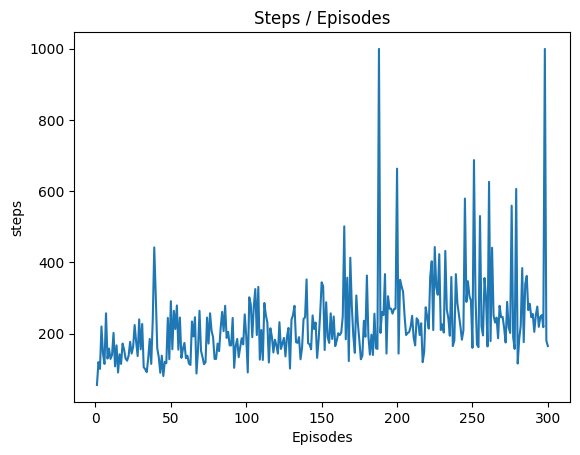

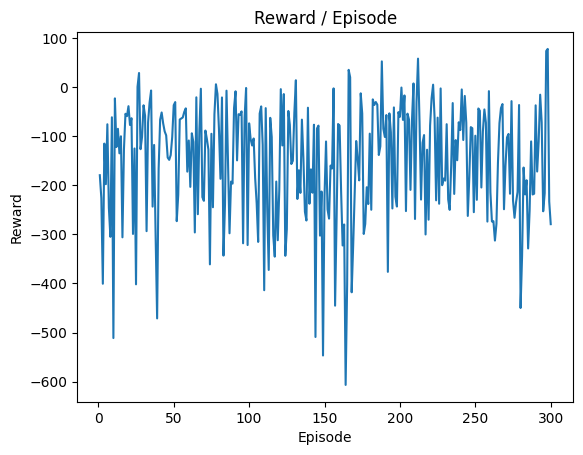

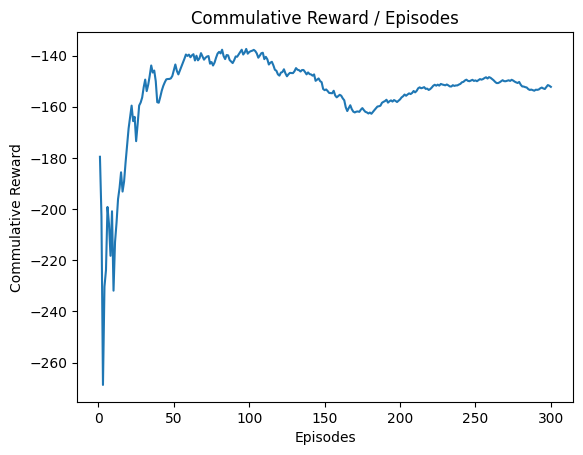

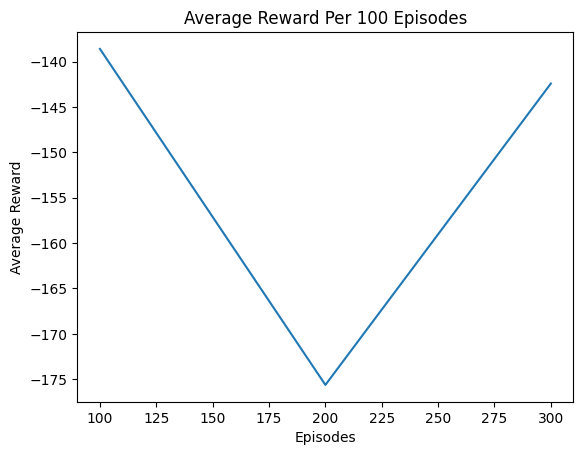

Moviepy - Building video /content/folder/video--episode-300.mp4.
Moviepy - Writing video /content/folder/video--episode-300.mp4



Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-300.mp4


Moviepy - Building video /content/folder/video--episode-300.mp4.
Moviepy - Writing video /content/folder/video--episode-300.mp4



Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-300.mp4
total episodes: 300
total time: 5.173970460891724
total steps to complete the episode: 347
reward for current state: -100
reward for this episode: -253.83488330523616


total episodes: 301
total time: 1.840118646621704
total steps to complete the episode: 297
reward for current state: -100
reward for this episode: -17.712170745048837


total episodes: 302
total time: 3.8805596828460693
total steps to complete the episode: 486
reward for current state: -100
reward for this episode: -274.0512980404395


total episodes: 303
total time: 2.082385778427124
total steps to complete the episode: 329
reward for current state: -100
reward for this episode: -315.1093691710781


total episodes: 304
total time: 7.71112322807312
total steps to complete the episode: 999
reward for current state: 1.227597272395294
reward for this episode: 43.01374807182284


total episodes: 305
total time: 1.401533842086792
total steps to com

Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-350.mp4


Moviepy - Building video /content/folder/video--episode-350.mp4.
Moviepy - Writing video /content/folder/video--episode-350.mp4



Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-350.mp4
total episodes: 350
total time: 10.472333908081055
total steps to complete the episode: 686
reward for current state: 100
reward for this episode: 267.27702053889266


total episodes: 351
total time: 2.4249331951141357
total steps to complete the episode: 273
reward for current state: -100
reward for this episode: -207.7253297497087


total episodes: 352
total time: 2.0359981060028076
total steps to complete the episode: 318
reward for current state: -100
reward for this episode: -250.8429464528237


total episodes: 353
total time: 1.6959009170532227
total steps to complete the episode: 274
reward for current state: -100
reward for this episode: -233.01065170199672


total episodes: 354
total time: 0.8738808631896973
total steps to complete the episode: 143
reward for current state: -100
reward for this episode: -70.48815152427014


total episodes: 355
total time: 2.0516464710235596
total steps to complete th

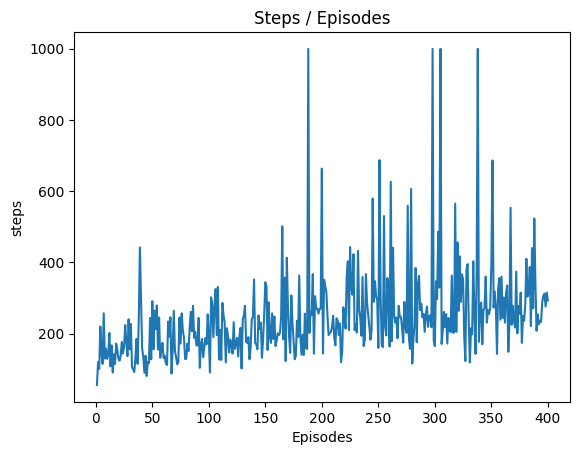

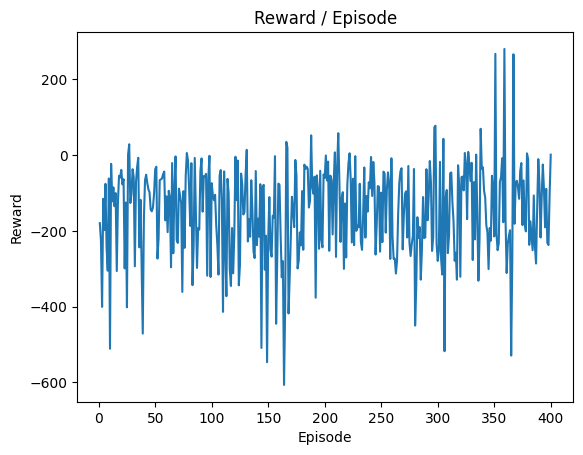

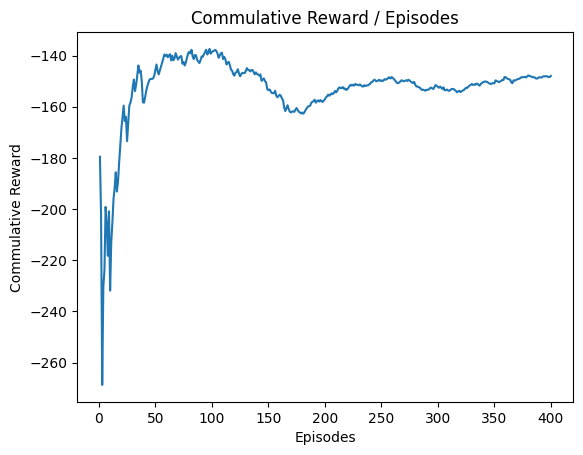

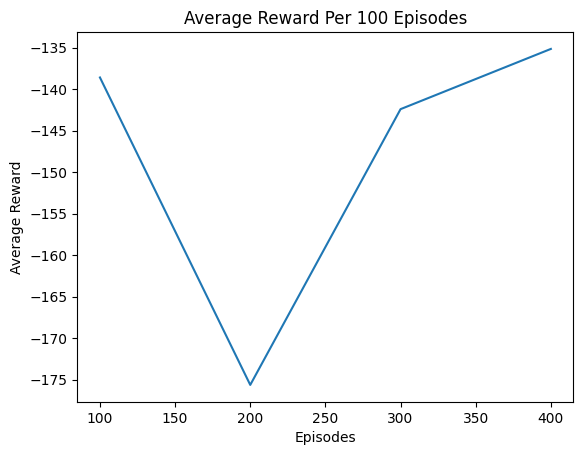

Moviepy - Building video /content/folder/video--episode-400.mp4.
Moviepy - Writing video /content/folder/video--episode-400.mp4



Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-400.mp4


Moviepy - Building video /content/folder/video--episode-400.mp4.
Moviepy - Writing video /content/folder/video--episode-400.mp4



Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-400.mp4
total episodes: 400
total time: 1.8067679405212402
total steps to complete the episode: 98
reward for current state: -100
reward for this episode: -135.88564199800075


total episodes: 401
total time: 1.8221006393432617
total steps to complete the episode: 205
reward for current state: -100
reward for this episode: 15.904641055746538


total episodes: 402
total time: 1.8412327766418457
total steps to complete the episode: 280
reward for current state: -100
reward for this episode: -226.49357762575306


total episodes: 403
total time: 1.6142761707305908
total steps to complete the episode: 254
reward for current state: -100
reward for this episode: -65.26966821861413


total episodes: 404
total time: 1.5030243396759033
total steps to complete the episode: 233
reward for current state: -100
reward for this episode: -184.69673660971455


total episodes: 405
total time: 1.7525665760040283
total steps to complete 

Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-450.mp4


Moviepy - Building video /content/folder/video--episode-450.mp4.
Moviepy - Writing video /content/folder/video--episode-450.mp4



Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-450.mp4
total episodes: 450
total time: 5.634229898452759
total steps to complete the episode: 344
reward for current state: -100
reward for this episode: -23.935005400342845


total episodes: 451
total time: 3.1791751384735107
total steps to complete the episode: 438
reward for current state: -100
reward for this episode: -76.84323528441149


total episodes: 452
total time: 2.95505428314209
total steps to complete the episode: 382
reward for current state: -100
reward for this episode: -201.950421219453


total episodes: 453
total time: 3.569669008255005
total steps to complete the episode: 457
reward for current state: -100
reward for this episode: -246.503412550893


total episodes: 454
total time: 2.3221797943115234
total steps to complete the episode: 345
reward for current state: -100
reward for this episode: -79.5882244999325


total episodes: 455
total time: 0.5997514724731445
total steps to complete the epis

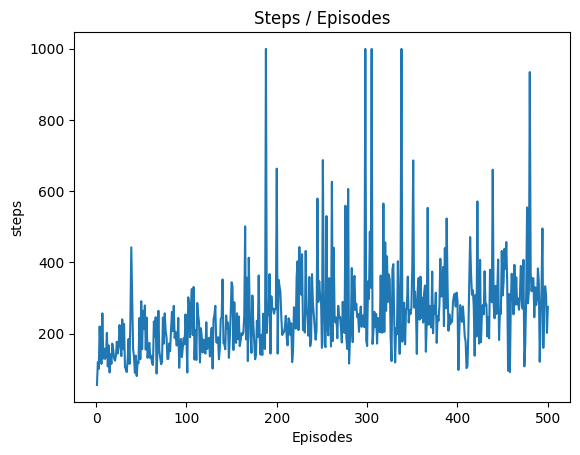

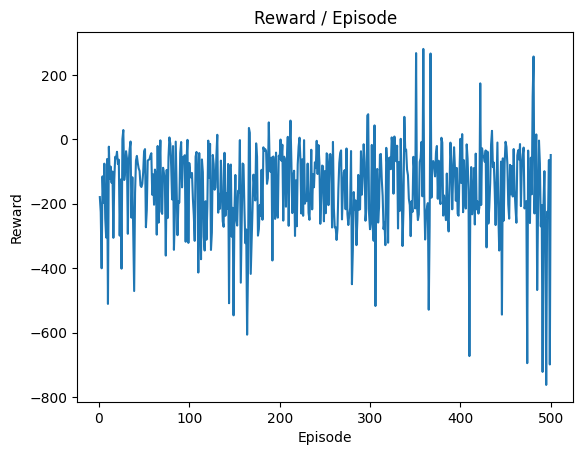

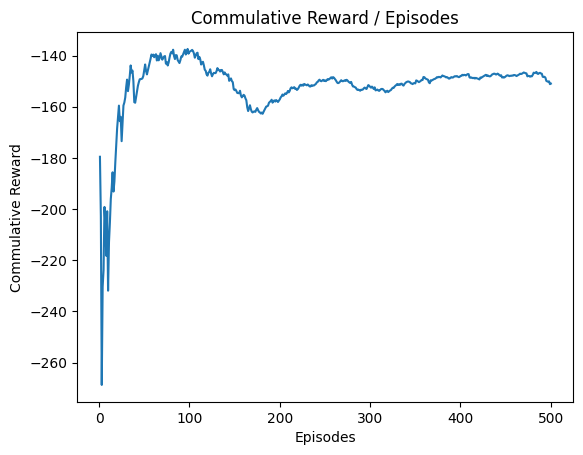

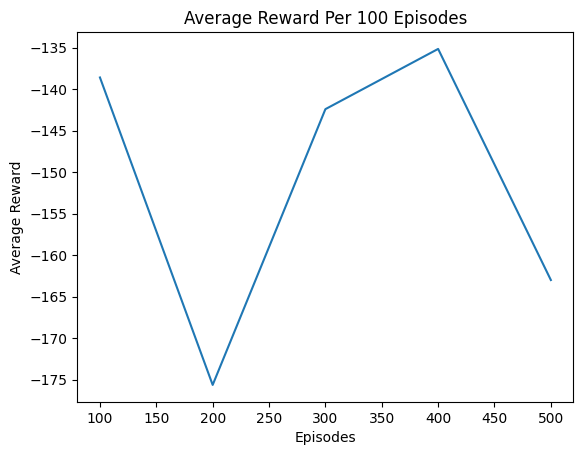

Moviepy - Building video /content/folder/video--episode-500.mp4.
Moviepy - Writing video /content/folder/video--episode-500.mp4



Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-500.mp4


Moviepy - Building video /content/folder/video--episode-500.mp4.
Moviepy - Writing video /content/folder/video--episode-500.mp4



Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-500.mp4
total episodes: 500
total time: 3.1720027923583984
total steps to complete the episode: 181
reward for current state: -100
reward for this episode: -109.51720624939553


total episodes: 501
total time: 2.389303684234619
total steps to complete the episode: 332
reward for current state: -100
reward for this episode: -51.7270888034912


total episodes: 502
total time: 2.7252566814422607
total steps to complete the episode: 359
reward for current state: -100
reward for this episode: -269.00080973232974


total episodes: 503
total time: 1.587989330291748
total steps to complete the episode: 228
reward for current state: -100
reward for this episode: -165.55557733189008


total episodes: 504
total time: 4.171934604644775
total steps to complete the episode: 464
reward for current state: -100
reward for this episode: -262.1507448924657


total episodes: 505
total time: 3.1532201766967773
total steps to complete the

Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-550.mp4


Moviepy - Building video /content/folder/video--episode-550.mp4.
Moviepy - Writing video /content/folder/video--episode-550.mp4



Moviepy - Done !
Moviepy - video ready /content/folder/video--episode-550.mp4
total episodes: 550
total time: 10.696875095367432
total steps to complete the episode: 611
reward for current state: -100
reward for this episode: -290.84837776771025


total episodes: 551
total time: 2.9525811672210693
total steps to complete the episode: 406
reward for current state: -100
reward for this episode: -273.2760943401412


total episodes: 552
total time: 2.147075653076172
total steps to complete the episode: 291
reward for current state: -100
reward for this episode: -244.8905064313645


total episodes: 553
total time: 2.720463514328003
total steps to complete the episode: 290
reward for current state: -100
reward for this episode: -205.70586263075398


total episodes: 554
total time: 1.4838199615478516
total steps to complete the episode: 206
reward for current state: -100
reward for this episode: -339.03700068632634


total episodes: 555
total time: 4.179096221923828
total steps to complete th

In [ ]:
result = testbed(epi=1000, steps_taken=1000, epsilon=0.5, min_epsilon=0.01, epsilon_decay=0.001, batch_size=32, gamma=0.99, lr=0.001, fc_1=256, fc_2=128, fc_3=64)

In [ ]:
# Graphs visualization

episodes, steps_per_episode, episode_rewards = result
plot_steps_per_episode(episodes, steps_per_episode)
plot_rewards_per_episode(episodes, episode_rewards)
plot_cumulative_rewards(episodes, episode_rewards)
plot_average_reward_per_hundred_episodes(episodes, episode_rewards)